In [1]:
import os
import torchvision.models as models 
import torch.nn as nn
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.notebook import tqdm
import torchmetrics
import cv2
device0 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

dataload

In [2]:
#fit
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum = carry
        while m*N - n*M < M :
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    return res

class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform/train/'
test_csv_path ='../../data/AF/Waveform/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,250)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,250)
test_label=torch.empty(len(test_data_list),1)
for i in range(len(train_data_list)):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    train_data[i]=torch.tensor(resized(signal_csv,250))
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in range(len(test_data_list)):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(resized(signal_csv,250))
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model

In [3]:
from sympy import flatten


class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(500, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,1,250))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [256, 1]                  --
├─Conv1d: 1-1                            [256, 50, 250]            200
├─ReLU: 1-2                              [256, 50, 250]            --
├─Dropout1d: 1-3                         [256, 50, 250]            --
├─MaxPool1d: 1-4                         [256, 50, 50]             --
├─Conv1d: 1-5                            [256, 50, 50]             7,550
├─ReLU: 1-6                              [256, 50, 50]             --
├─Dropout1d: 1-7                         [256, 50, 50]             --
├─MaxPool1d: 1-8                         [256, 50, 10]             --
├─Linear: 1-9                            [256, 200]                100,000
├─Linear: 1-10                           [256, 1]                  200
Total params: 107,950
Trainable params: 107,950
Non-trainable params: 0
Total mult-adds (M): 135.09
Input size (MB): 0.26
Forward/backward pass s

Train

epoch: 1/1000 train_loss : 0.6735 train_accuracy: 0.5599 val_loss : 0.6048  val_accuracy: 0.6129
epoch: 2/1000 train_loss : 0.6168 train_accuracy: 0.6186 val_loss : 0.5214  val_accuracy: 0.7201


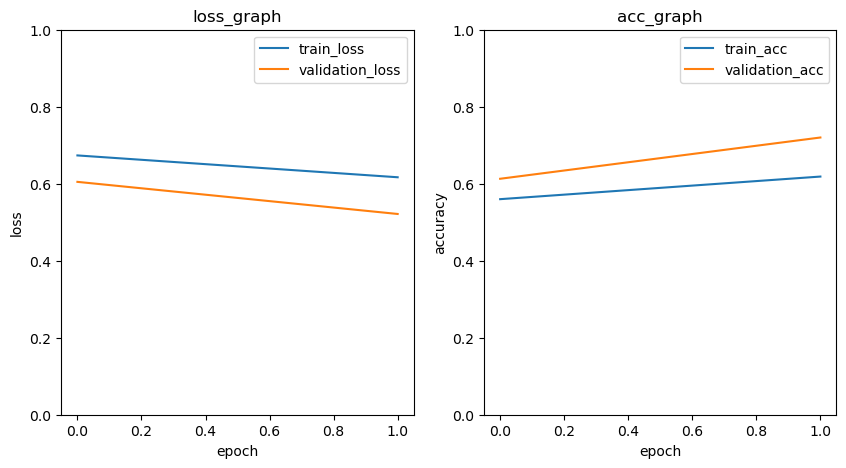

epoch: 3/1000 train_loss : 0.5666 train_accuracy: 0.6877 val_loss : 0.4859  val_accuracy: 0.7469
epoch: 4/1000 train_loss : 0.5310 train_accuracy: 0.7208 val_loss : 0.4560  val_accuracy: 0.7774
epoch: 5/1000 train_loss : 0.5058 train_accuracy: 0.7438 val_loss : 0.4163  val_accuracy: 0.8167
epoch: 6/1000 train_loss : 0.4878 train_accuracy: 0.7583 val_loss : 0.3970  val_accuracy: 0.8270
epoch: 7/1000 train_loss : 0.4728 train_accuracy: 0.7714 val_loss : 0.3792  val_accuracy: 0.8431
epoch: 8/1000 train_loss : 0.4660 train_accuracy: 0.7768 val_loss : 0.3772  val_accuracy: 0.8278
epoch: 9/1000 train_loss : 0.4569 train_accuracy: 0.7827 val_loss : 0.3797  val_accuracy: 0.8354
epoch: 10/1000 train_loss : 0.4530 train_accuracy: 0.7870 val_loss : 0.3654  val_accuracy: 0.8486
epoch: 11/1000 train_loss : 0.4461 train_accuracy: 0.7904 val_loss : 0.3662  val_accuracy: 0.8420
epoch: 12/1000 train_loss : 0.4405 train_accuracy: 0.7938 val_loss : 0.3465  val_accuracy: 0.8581
epoch: 13/1000 train_loss :

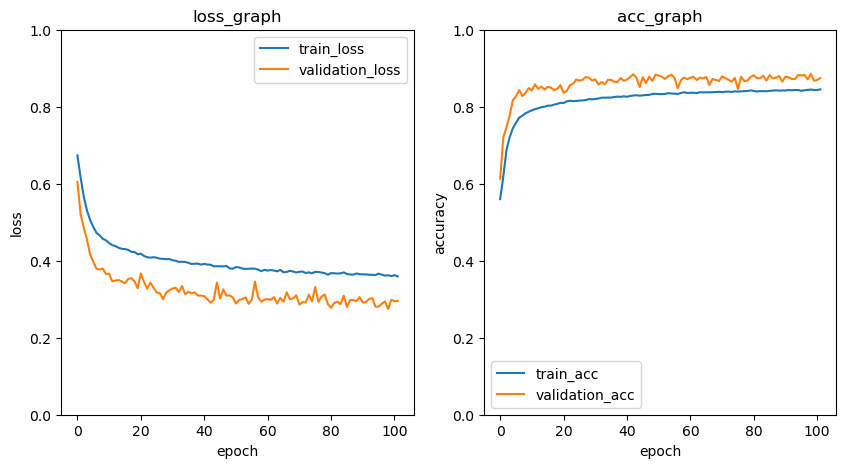

epoch: 103/1000 train_loss : 0.3637 train_accuracy: 0.8440 val_loss : 0.2868  val_accuracy: 0.8809
epoch: 104/1000 train_loss : 0.3617 train_accuracy: 0.8448 val_loss : 0.2836  val_accuracy: 0.8784
epoch: 105/1000 train_loss : 0.3565 train_accuracy: 0.8439 val_loss : 0.3098  val_accuracy: 0.8722
epoch: 106/1000 train_loss : 0.3606 train_accuracy: 0.8446 val_loss : 0.2757  val_accuracy: 0.8811
epoch: 107/1000 train_loss : 0.3612 train_accuracy: 0.8448 val_loss : 0.2879  val_accuracy: 0.8804
epoch: 108/1000 train_loss : 0.3606 train_accuracy: 0.8443 val_loss : 0.3127  val_accuracy: 0.8634
epoch: 109/1000 train_loss : 0.3599 train_accuracy: 0.8439 val_loss : 0.3040  val_accuracy: 0.8665
epoch: 110/1000 train_loss : 0.3585 train_accuracy: 0.8440 val_loss : 0.2837  val_accuracy: 0.8780
epoch: 111/1000 train_loss : 0.3577 train_accuracy: 0.8454 val_loss : 0.2720  val_accuracy: 0.8858
epoch: 112/1000 train_loss : 0.3611 train_accuracy: 0.8440 val_loss : 0.2975  val_accuracy: 0.8719
epoch: 113

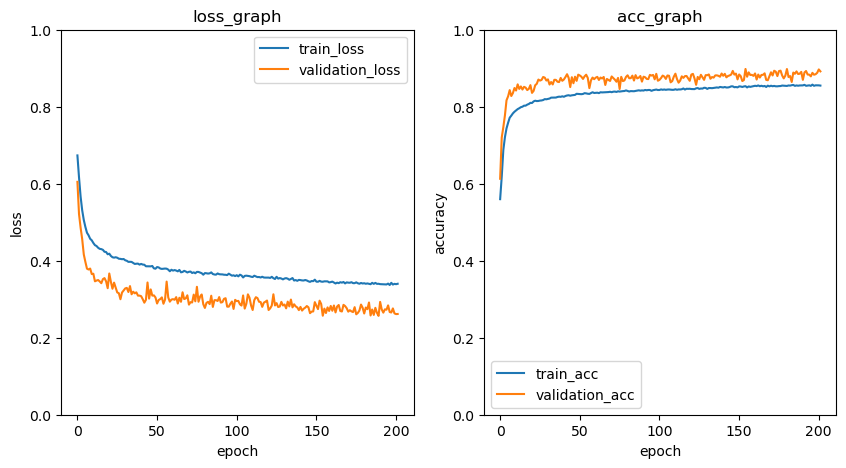

epoch: 203/1000 train_loss : 0.3395 train_accuracy: 0.8570 val_loss : 0.2750  val_accuracy: 0.8751
epoch: 204/1000 train_loss : 0.3382 train_accuracy: 0.8577 val_loss : 0.2889  val_accuracy: 0.8724
epoch: 205/1000 train_loss : 0.3424 train_accuracy: 0.8536 val_loss : 0.2706  val_accuracy: 0.8831
epoch: 206/1000 train_loss : 0.3393 train_accuracy: 0.8561 val_loss : 0.2601  val_accuracy: 0.8966
epoch: 207/1000 train_loss : 0.3387 train_accuracy: 0.8577 val_loss : 0.2638  val_accuracy: 0.8896
epoch: 208/1000 train_loss : 0.3394 train_accuracy: 0.8571 val_loss : 0.2729  val_accuracy: 0.8823
epoch: 209/1000 train_loss : 0.3380 train_accuracy: 0.8576 val_loss : 0.2546  val_accuracy: 0.8986
epoch: 210/1000 train_loss : 0.3366 train_accuracy: 0.8575 val_loss : 0.2675  val_accuracy: 0.8820
epoch: 211/1000 train_loss : 0.3393 train_accuracy: 0.8563 val_loss : 0.2730  val_accuracy: 0.8861
epoch: 212/1000 train_loss : 0.3402 train_accuracy: 0.8563 val_loss : 0.2596  val_accuracy: 0.8927
epoch: 213

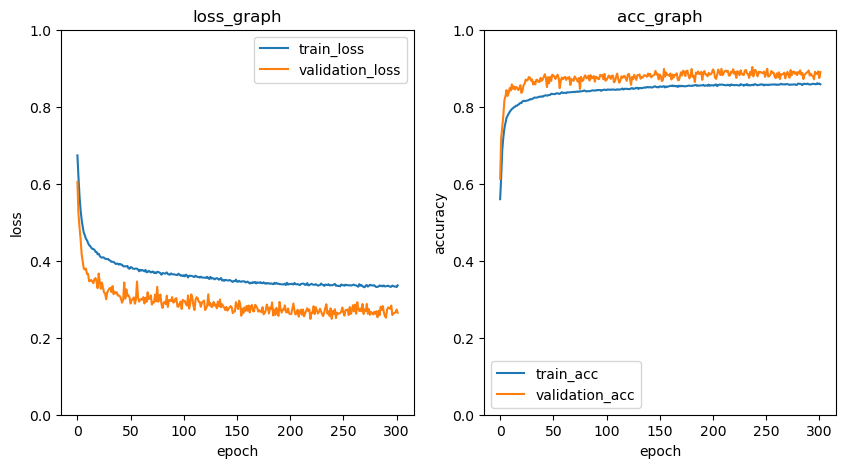

epoch: 303/1000 train_loss : 0.3362 train_accuracy: 0.8580 val_loss : 0.2682  val_accuracy: 0.8895
epoch: 304/1000 train_loss : 0.3327 train_accuracy: 0.8603 val_loss : 0.2636  val_accuracy: 0.8860
epoch: 305/1000 train_loss : 0.3328 train_accuracy: 0.8598 val_loss : 0.2618  val_accuracy: 0.8844
epoch: 306/1000 train_loss : 0.3328 train_accuracy: 0.8607 val_loss : 0.2591  val_accuracy: 0.8938
epoch: 307/1000 train_loss : 0.3365 train_accuracy: 0.8584 val_loss : 0.2752  val_accuracy: 0.8846
epoch: 308/1000 train_loss : 0.3313 train_accuracy: 0.8600 val_loss : 0.2632  val_accuracy: 0.8861
epoch: 309/1000 train_loss : 0.3374 train_accuracy: 0.8576 val_loss : 0.2710  val_accuracy: 0.8913
epoch: 310/1000 train_loss : 0.3341 train_accuracy: 0.8574 val_loss : 0.2558  val_accuracy: 0.8958
epoch: 311/1000 train_loss : 0.3322 train_accuracy: 0.8592 val_loss : 0.2859  val_accuracy: 0.8731
epoch: 312/1000 train_loss : 0.3298 train_accuracy: 0.8617 val_loss : 0.2511  val_accuracy: 0.8949
epoch: 313

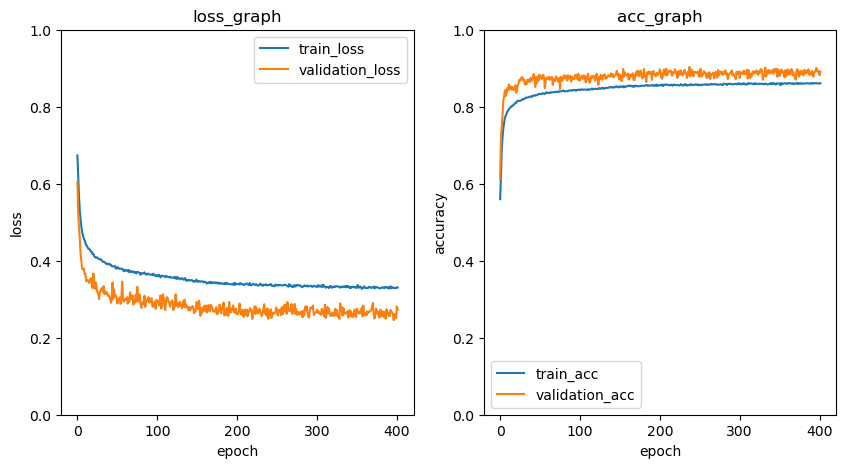

epoch: 403/1000 train_loss : 0.3282 train_accuracy: 0.8613 val_loss : 0.2783  val_accuracy: 0.8789
epoch: 404/1000 train_loss : 0.3299 train_accuracy: 0.8619 val_loss : 0.2613  val_accuracy: 0.8923
epoch: 405/1000 train_loss : 0.3285 train_accuracy: 0.8620 val_loss : 0.2716  val_accuracy: 0.8862
epoch: 406/1000 train_loss : 0.3299 train_accuracy: 0.8606 val_loss : 0.2568  val_accuracy: 0.8918
epoch: 407/1000 train_loss : 0.3271 train_accuracy: 0.8605 val_loss : 0.2563  val_accuracy: 0.8875
epoch: 408/1000 train_loss : 0.3301 train_accuracy: 0.8599 val_loss : 0.2684  val_accuracy: 0.8881
epoch: 409/1000 train_loss : 0.3291 train_accuracy: 0.8617 val_loss : 0.2598  val_accuracy: 0.8899
epoch: 410/1000 train_loss : 0.3275 train_accuracy: 0.8604 val_loss : 0.2690  val_accuracy: 0.8831
epoch: 411/1000 train_loss : 0.3295 train_accuracy: 0.8615 val_loss : 0.2669  val_accuracy: 0.8880
epoch: 412/1000 train_loss : 0.3271 train_accuracy: 0.8607 val_loss : 0.2707  val_accuracy: 0.8770
epoch: 413

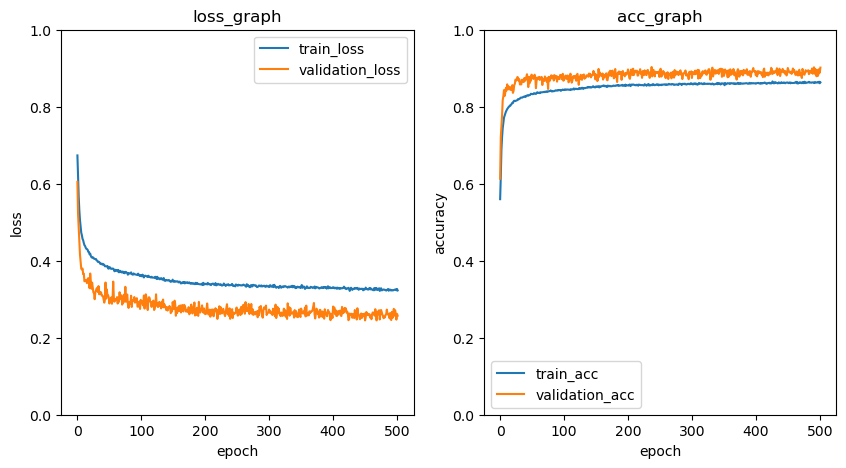

epoch: 503/1000 train_loss : 0.3241 train_accuracy: 0.8639 val_loss : 0.2502  val_accuracy: 0.8948
epoch: 504/1000 train_loss : 0.3273 train_accuracy: 0.8627 val_loss : 0.2522  val_accuracy: 0.8926
epoch: 505/1000 train_loss : 0.3257 train_accuracy: 0.8636 val_loss : 0.2640  val_accuracy: 0.8879
epoch: 506/1000 train_loss : 0.3225 train_accuracy: 0.8636 val_loss : 0.2700  val_accuracy: 0.8797
epoch: 507/1000 train_loss : 0.3243 train_accuracy: 0.8618 val_loss : 0.2570  val_accuracy: 0.8913
epoch: 508/1000 train_loss : 0.3210 train_accuracy: 0.8650 val_loss : 0.2577  val_accuracy: 0.8848
epoch: 509/1000 train_loss : 0.3261 train_accuracy: 0.8619 val_loss : 0.2463  val_accuracy: 0.8950
epoch: 510/1000 train_loss : 0.3240 train_accuracy: 0.8629 val_loss : 0.2460  val_accuracy: 0.9003
epoch: 511/1000 train_loss : 0.3215 train_accuracy: 0.8636 val_loss : 0.2509  val_accuracy: 0.8931
epoch: 512/1000 train_loss : 0.3208 train_accuracy: 0.8635 val_loss : 0.2567  val_accuracy: 0.8910
epoch: 513

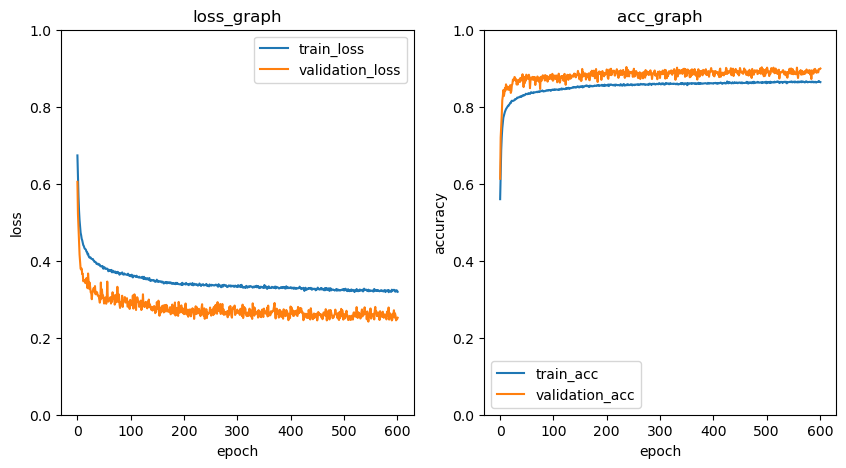

epoch: 603/1000 train_loss : 0.3232 train_accuracy: 0.8643 val_loss : 0.2583  val_accuracy: 0.8918
epoch: 604/1000 train_loss : 0.3234 train_accuracy: 0.8634 val_loss : 0.2540  val_accuracy: 0.8944
epoch: 605/1000 train_loss : 0.3195 train_accuracy: 0.8643 val_loss : 0.2551  val_accuracy: 0.8957
epoch: 606/1000 train_loss : 0.3217 train_accuracy: 0.8646 val_loss : 0.2610  val_accuracy: 0.8945
epoch: 607/1000 train_loss : 0.3197 train_accuracy: 0.8655 val_loss : 0.2476  val_accuracy: 0.8960
epoch: 608/1000 train_loss : 0.3211 train_accuracy: 0.8650 val_loss : 0.2586  val_accuracy: 0.8931
epoch: 609/1000 train_loss : 0.3211 train_accuracy: 0.8647 val_loss : 0.2527  val_accuracy: 0.8885
epoch: 610/1000 train_loss : 0.3218 train_accuracy: 0.8646 val_loss : 0.2518  val_accuracy: 0.8912
epoch: 611/1000 train_loss : 0.3194 train_accuracy: 0.8656 val_loss : 0.2468  val_accuracy: 0.8985
epoch: 612/1000 train_loss : 0.3207 train_accuracy: 0.8660 val_loss : 0.2705  val_accuracy: 0.8840
epoch: 613

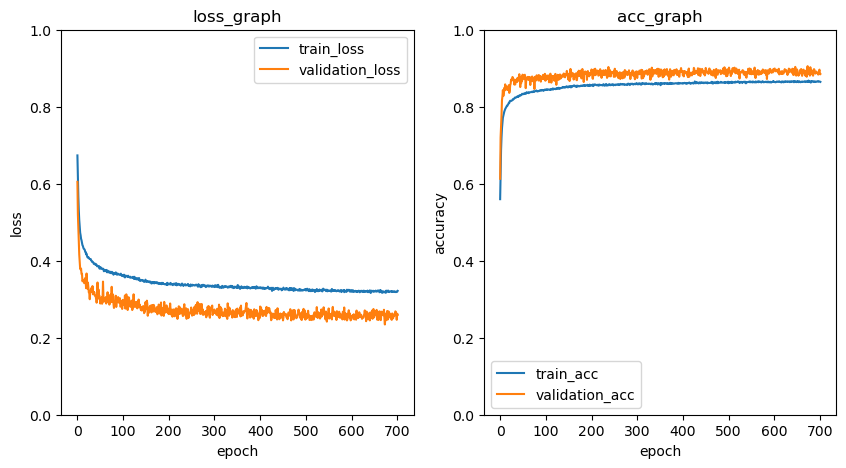

epoch: 703/1000 train_loss : 0.3217 train_accuracy: 0.8650 val_loss : 0.2590  val_accuracy: 0.8912
epoch: 704/1000 train_loss : 0.3162 train_accuracy: 0.8672 val_loss : 0.2542  val_accuracy: 0.8844
epoch: 705/1000 train_loss : 0.3175 train_accuracy: 0.8659 val_loss : 0.2536  val_accuracy: 0.8963
epoch: 706/1000 train_loss : 0.3196 train_accuracy: 0.8656 val_loss : 0.2705  val_accuracy: 0.8759
epoch: 707/1000 train_loss : 0.3222 train_accuracy: 0.8654 val_loss : 0.2700  val_accuracy: 0.8816
epoch: 708/1000 train_loss : 0.3204 train_accuracy: 0.8655 val_loss : 0.2441  val_accuracy: 0.8986
epoch: 709/1000 train_loss : 0.3196 train_accuracy: 0.8653 val_loss : 0.2560  val_accuracy: 0.8922
epoch: 710/1000 train_loss : 0.3208 train_accuracy: 0.8646 val_loss : 0.2533  val_accuracy: 0.8902
epoch: 711/1000 train_loss : 0.3200 train_accuracy: 0.8656 val_loss : 0.2505  val_accuracy: 0.8953
epoch: 712/1000 train_loss : 0.3185 train_accuracy: 0.8667 val_loss : 0.2631  val_accuracy: 0.8879
epoch: 713

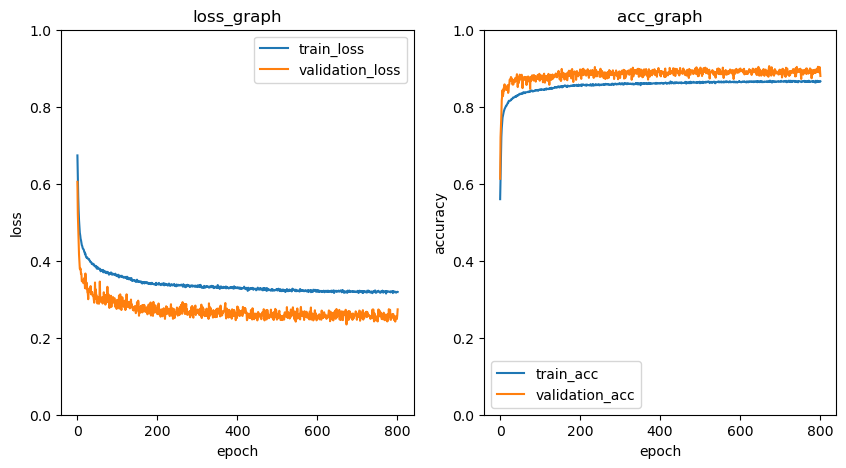

epoch: 803/1000 train_loss : 0.3203 train_accuracy: 0.8654 val_loss : 0.2594  val_accuracy: 0.8858
epoch: 804/1000 train_loss : 0.3182 train_accuracy: 0.8663 val_loss : 0.2579  val_accuracy: 0.8925
epoch: 805/1000 train_loss : 0.3211 train_accuracy: 0.8644 val_loss : 0.2607  val_accuracy: 0.8877
epoch: 806/1000 train_loss : 0.3191 train_accuracy: 0.8653 val_loss : 0.2687  val_accuracy: 0.8806
epoch: 807/1000 train_loss : 0.3180 train_accuracy: 0.8666 val_loss : 0.2506  val_accuracy: 0.8967
epoch: 808/1000 train_loss : 0.3178 train_accuracy: 0.8668 val_loss : 0.2535  val_accuracy: 0.8907
epoch: 809/1000 train_loss : 0.3186 train_accuracy: 0.8661 val_loss : 0.2495  val_accuracy: 0.8960
epoch: 810/1000 train_loss : 0.3136 train_accuracy: 0.8675 val_loss : 0.2449  val_accuracy: 0.8977
epoch: 811/1000 train_loss : 0.3169 train_accuracy: 0.8662 val_loss : 0.2575  val_accuracy: 0.8933
epoch: 812/1000 train_loss : 0.3187 train_accuracy: 0.8663 val_loss : 0.2640  val_accuracy: 0.8856
epoch: 813

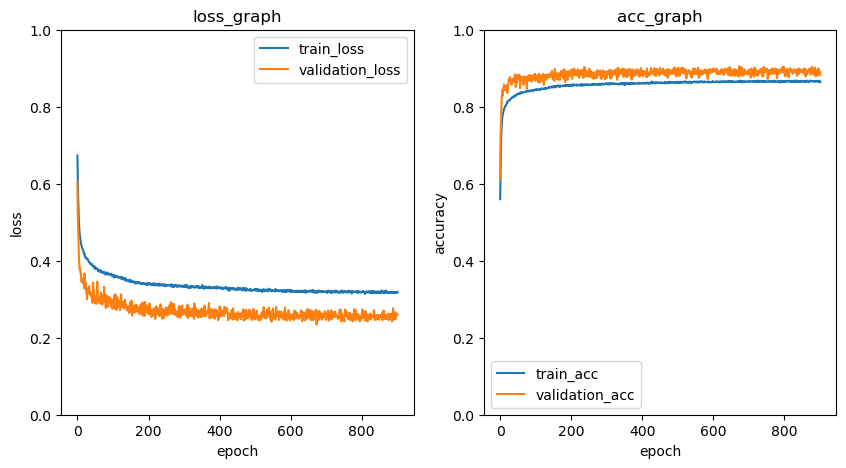

epoch: 903/1000 train_loss : 0.3185 train_accuracy: 0.8675 val_loss : 0.2517  val_accuracy: 0.8948
epoch: 904/1000 train_loss : 0.3207 train_accuracy: 0.8650 val_loss : 0.2740  val_accuracy: 0.8831
epoch: 905/1000 train_loss : 0.3195 train_accuracy: 0.8653 val_loss : 0.2603  val_accuracy: 0.8859
epoch: 906/1000 train_loss : 0.3170 train_accuracy: 0.8667 val_loss : 0.2608  val_accuracy: 0.8900
epoch: 907/1000 train_loss : 0.3172 train_accuracy: 0.8674 val_loss : 0.2370  val_accuracy: 0.9022
epoch: 908/1000 train_loss : 0.3196 train_accuracy: 0.8653 val_loss : 0.2666  val_accuracy: 0.8850
epoch: 909/1000 train_loss : 0.3190 train_accuracy: 0.8655 val_loss : 0.2726  val_accuracy: 0.8777
epoch: 910/1000 train_loss : 0.3183 train_accuracy: 0.8646 val_loss : 0.2559  val_accuracy: 0.8914
epoch: 911/1000 train_loss : 0.3181 train_accuracy: 0.8658 val_loss : 0.2631  val_accuracy: 0.8826
epoch: 912/1000 train_loss : 0.3175 train_accuracy: 0.8677 val_loss : 0.2468  val_accuracy: 0.9012
epoch: 913

In [4]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_10_25hz_TypeAll_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_10_25hz_TypeAll.pt')

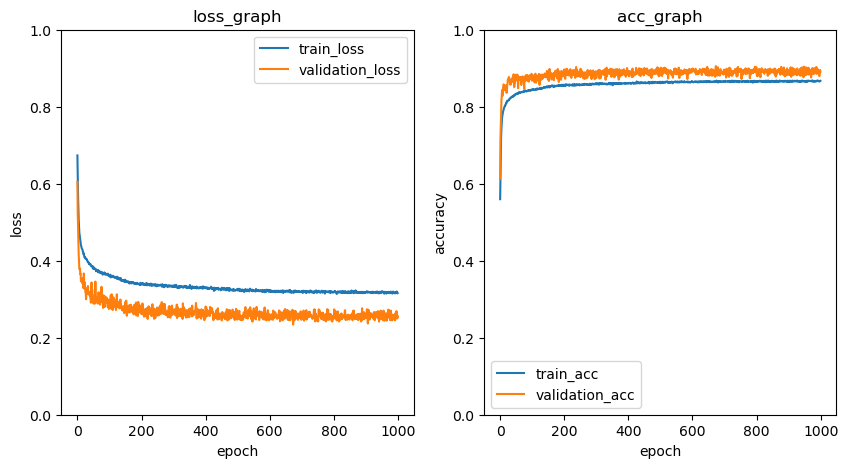

: 

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()